In [1]:
from dataclasses import dataclass
from typing import Callable

import pandas as pd
import os, json, re

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.cluster import KMeans

import pprint

SAMPLE_DIR = './sample/samples-1000'

# Data exploration and transformation

## price analysis

In [2]:
prices = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith('.json'):
        with open(os.path.join(SAMPLE_DIR, file)) as f:
            data = json.load(f)
            prices.append(data['note'])

# printing first 20 elements to get what it looks like without polluting the output prompt
prices[:20]

['~b/o 4 chaos',
 '~price 2 divine',
 '~price 4 chaos',
 '~b/o 1 divine',
 '~price 50 chaos',
 '~b/o 58 chaos',
 '~price 10 chaos',
 '~price 10 chaos',
 '~price 9 chaos',
 '~b/o 50 chaos',
 '~price 3 chaos 4',
 '~b/o 31 chaos',
 '~price 1 chaos',
 '~b/o 5 chaos',
 '~price 2 chaos veiled',
 '~price 5 chaos',
 '~price 1 divine',
 '~price 2 chaos',
 '~b/o 30 chaos',
 '~b/o 31 chaos']

In [3]:
@dataclass
class PatternConverter:
    pattern: re.Pattern
    conversion_factor: Callable[[str], float]


chaos_pattern = PatternConverter(re.compile(r'^~price \d+ chaos$'), lambda s: int(s.split()[1]))
bo_chaos_pattern = PatternConverter(re.compile(r'^~b/o \d+ chaos$'), lambda s: int(s.split()[1]))
divine_pattern = PatternConverter(re.compile(r'^~price \d+ divine$'), lambda s: int(s.split()[1]) * 165)
bo_divine_pattern = PatternConverter(re.compile(r'^~b/o \d+ divine$'), lambda s: int(s.split()[1]) * 165)
chaos_veiled_pattern = PatternConverter(re.compile(r'^~price \d+ chaos veiled$'), lambda s: int(s.split()[1]) * 74.5)
bo_chaos_veiled_pattern = PatternConverter(re.compile(r'^~b/o \d+ chaos veiled$'), lambda s: int(s.split()[1]) * 74.5)

def match_any_patten_and_convert(string: str) -> float | None:
    for pattern in [chaos_pattern, bo_chaos_pattern, divine_pattern, bo_divine_pattern, chaos_veiled_pattern, bo_chaos_veiled_pattern]:
        if pattern.pattern.match(string):
            return pattern.conversion_factor(string)
    return None

filtered_prices = [interpreted_price for price in prices if (interpreted_price := match_any_patten_and_convert(price)) is not None]
filtered_out_prices = [price for price in prices if not match_any_patten_and_convert(price)]
# filtered_prices_values = [int(price.split()[1]) for price in filtered_prices]


In [4]:
price_distribution = pd.Series(filtered_prices).value_counts().sort_index()

# printing first 20 elements to get what it looks like without polluting the output prompt
price_distribution.head(20)

0.0       1
1.0      63
2.0      72
3.0      72
4.0      20
5.0     128
6.0      50
7.0       3
8.0      19
9.0      13
10.0    100
11.0     16
12.0     12
14.0      4
15.0     41
17.0      1
19.0      1
20.0     90
22.0      3
23.0      4
Name: count, dtype: int64

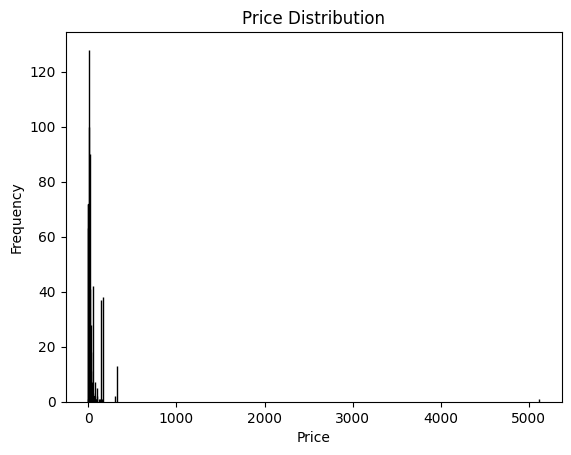

In [5]:
plt.bar(price_distribution.index, price_distribution.values, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

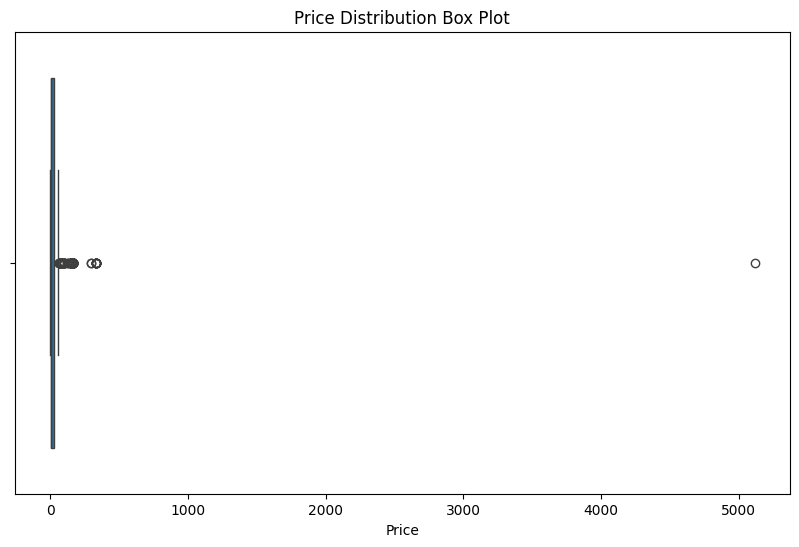

In [6]:
df = pd.DataFrame(filtered_prices, columns=['Price'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title('Price Distribution Box Plot')
plt.xlabel('Price')
plt.show()

## Cluster creation

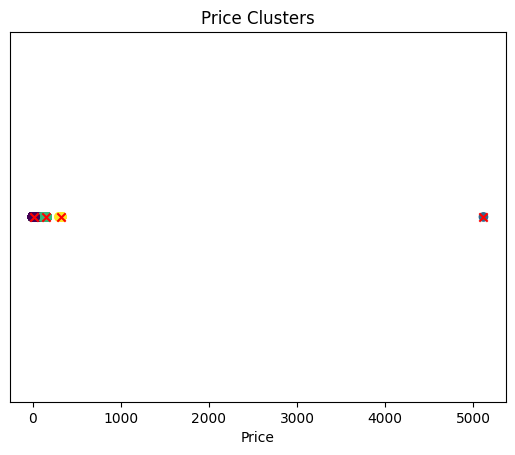

In [7]:
prices_array = np.array(filtered_prices).reshape(-1, 1)

# we assume 4 clusters: S, A, B, C
kmeans_with_outlier = KMeans(n_clusters=4, random_state=0)
price_clusters = kmeans_with_outlier.fit_predict(prices_array)

price_cluster_centers = kmeans_with_outlier.cluster_centers_ # for visualization

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers, [0]*len(price_cluster_centers), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

### elbow method for cluster number selection

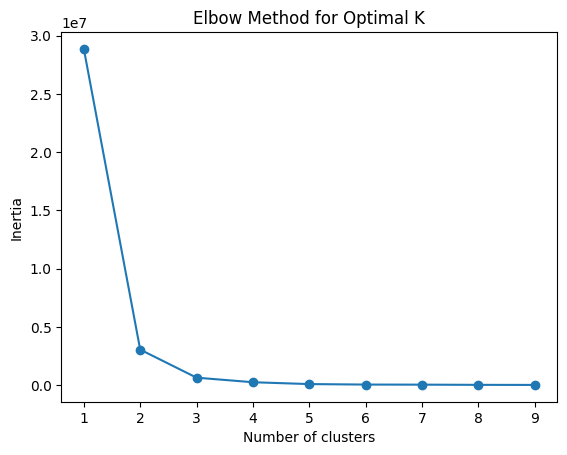

In [8]:
cluster_inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(prices_array)
    cluster_inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), cluster_inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Grouped clustering

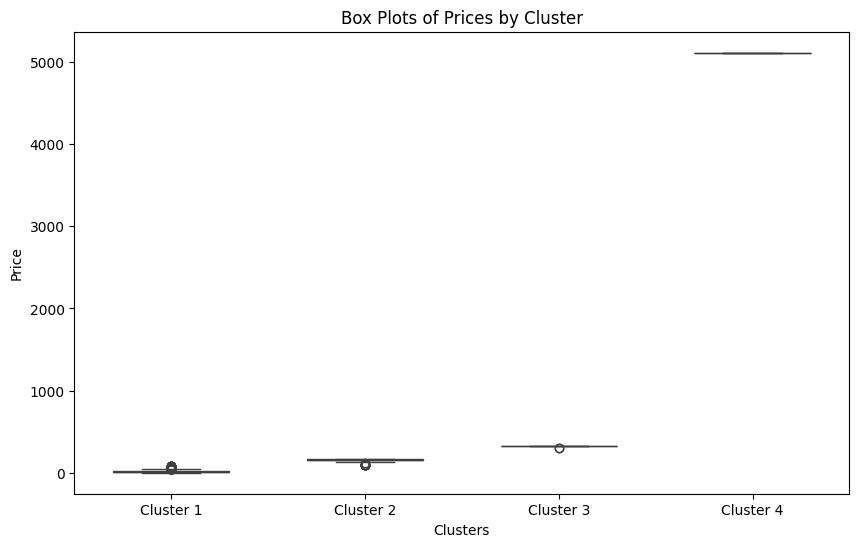

In [9]:


clustered_prices = {i: [] for i in range(4)}
for price, cluster in zip(prices_array, price_clusters):
    clustered_prices[cluster].append(price)

plt.figure(figsize=(10, 6))

colors = sns.color_palette("husl", 4) 
sorted_cluster_indices = np.argsort(kmeans_with_outlier.cluster_centers_.flatten())


all_prices = []
all_clusters = []

for sorted_index in sorted_cluster_indices:
    mask = price_clusters == sorted_index
    all_prices.extend(prices_array[mask])
    all_clusters.extend([sorted_cluster_indices.tolist().index(sorted_index)] * sum(mask))


all_clusters = list(map(int, all_clusters))
#all_prices = list(map(float, all_prices))
all_prices = [float(price.item()) if isinstance(price, np.ndarray) else float(price) for price in all_prices]


sns.boxplot(x=all_clusters, y=all_prices, palette=colors, hue=all_clusters, width=0.6, legend=False)

plt.xticks(range(len(sorted_cluster_indices)), [f'Cluster {i+1}' for i in range(len(sorted_cluster_indices))])
plt.xlabel('Clusters')
plt.ylabel('Price')
plt.title('Box Plots of Prices by Cluster')

plt.show()